# chile2010a -- Examples of grid refinement

This notebook walks through several experiments you can do in the directory `geoclaw_examples/chile2010a`.

The experiments are meant to be done from a the command line in a shell and `$` indicates the command line prompt.  This notebook provides a suggested sequence of steps.

The first thing to do in the `geoclaw_examples/chile2010a` directory is to download some topography and create an earthquake deformation file via:

    $ make topo
    
This simply runs the Python script `maketopo.py`.  Then 

    $ make .plots
    
will compile the code, create a set of files `*.data` based on parameters specified in `setrun.py`, run the program, and produce a set of plots that can be viewed with a web browser.

You can then modify the file `setrun.py` using an editor and saving the file, and then giving the command

    $ make .plots

will re-run the code with the modified parameters and produce a new set of plots. 

This notebook explains a set of experiments you might do and also shows some of the resulting plots.  In order to produce these plots, the GeoClaw code has been run from the notebook, so below you can also see how to work in this mode.  

## Notebook setup

The next few cells are need to set things up for running code in the notebook.  Skip to **Experiment 1** to get started with the experiments.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from clawpack.clawutil import nbtools
import clawpack.visclaw.JSAnimation.JSAnimation_frametools as J

In [3]:
nbtools.make_exe(new=True, verbose=False)  # compile GeoClaw

In [12]:
# create *.data files from parameters in setrun.py
from setrun_original import setrun
rundata = setrun()
rundata.write()      

In [13]:
run maketopo.py  # download the topo file and create the dtopo file

Skipping download... file already exists:  /Users/rjl/git/clawpack/geoclaw/scratch/etopo1_-140_-60_-60_10_10min.tt3
Earthquake moment magnitude Mw =  8.92
Not regenerating dtopo file (already exists): /Users/rjl/git/clawpack/geoclaw/scratch/dtopo_usgs100227.tt3


In [16]:
# Run the code with the original parameter settings
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)

## Experiment 1 -- One-level run on a coarse grid

As a first test, compile and run the code using the parameter values in the original `setrun.py` file in this directory.  (If you have been experimenting with it and want to recover the original, this same file is also in `setrun_original.py`.)

First download a topography file and create the seafloor deformation file if necessary.  **In a terminal window:**

    make topo
    
Compile the code:

    make .exe
    
Run the code and create plots:

    make .plots
    
Then you should be able to open the file `_plots/_PlotIndex.html` in a web browser and see the results, including an animation that looks like this:


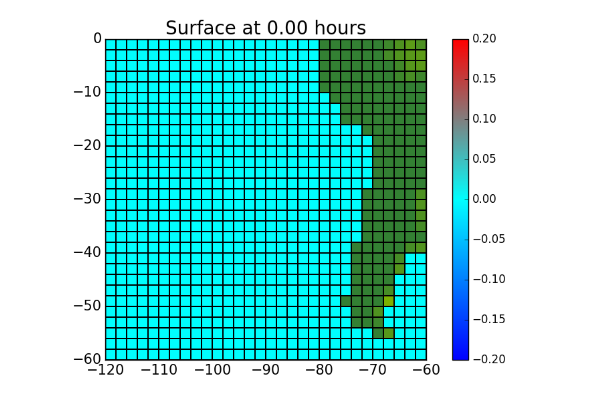
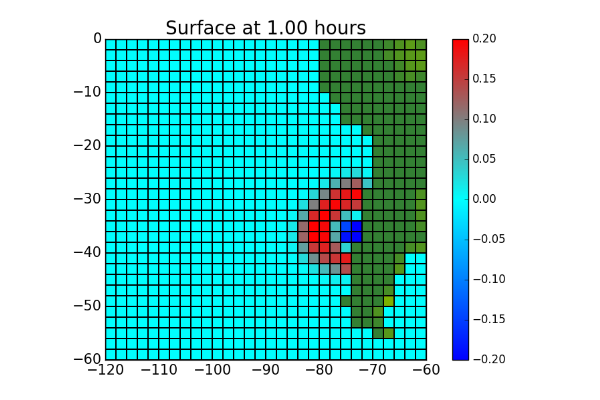
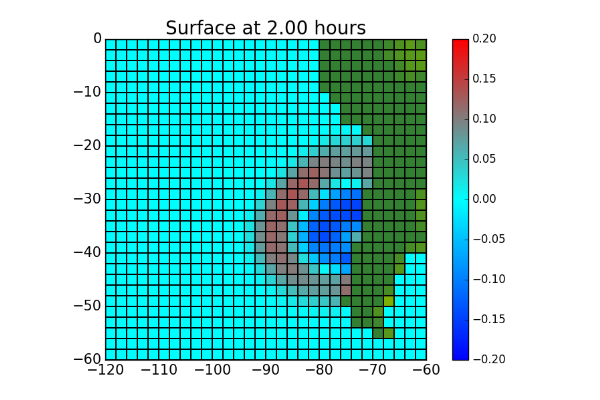
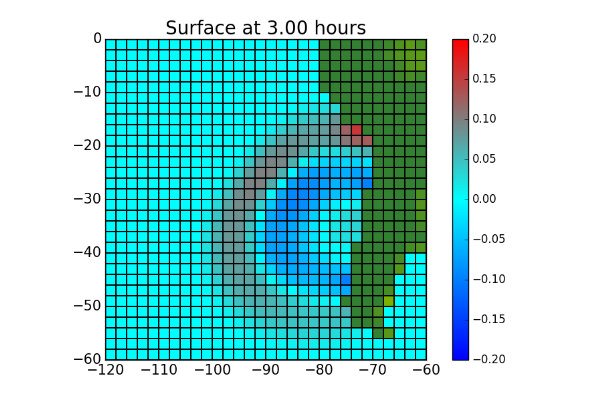
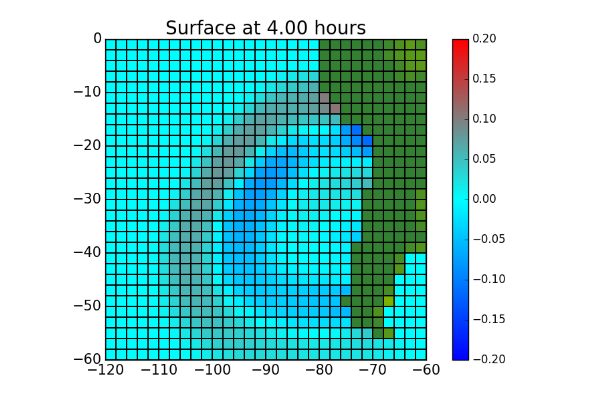
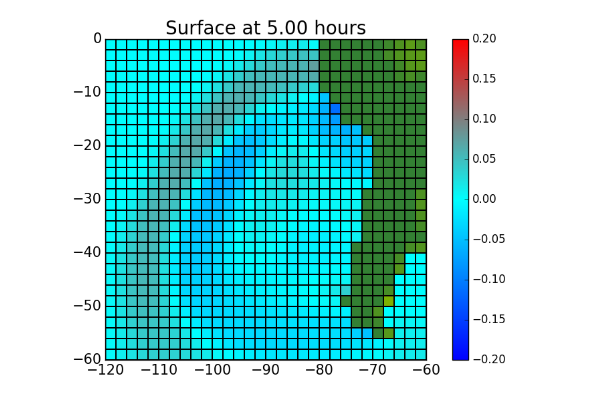

In [17]:
J.make_anim(plotdir, figno=0, figsize=(6,4))

## Experiment 2 - Add Level 2 grids with adaptive refinement

Experiment 1 above was run without grid refinement on a very coarse 30 by 30 grid -- each grid cell is 2 degrees (approximately 220 km) on a side and so the result is not very useful.

You could rerun the code with a finer grid by changing the following lines in `setrun.py`:

    # Number of grid cells: Coarsest grid
    clawdata.num_cells[0] = 30
    clawdata.num_cells[1] = 30
    
But over much of the domain nothing is happening, so a more efficient approach is to leave the resolution of this coarsest level 1 grid alone and instead add an additional level of refinement only where the wave is present.

Modify the lines (starting at line 282)

    # max number of refinement levels:
    amrdata.amr_levels_max = 1

to increase the maximum level allowed from 1 to 2:

    # max number of refinement levels:
    amrdata.amr_levels_max = 2
    
Note that the next lines read:

    # List of refinement ratios at each level:
    amrdata.refinement_ratios_x = [2]
    amrdata.refinement_ratios_y = [2]
    amrdata.refinement_ratios_t = [2]

This means that Level 2 grids will be 2 times finer than Level 1 grids in each direction. They will also be 2 times finer in t, meaning two time steps must be taken on each Level 2 grid for every time step on Level 1.  This is handled automatically within GeoClaw.

Now save `setrun.py` and re-execute `make .plots` to recreate the `_plots` directory.

The results should look like what is shown below, after making the same change in the notebook version of the code.


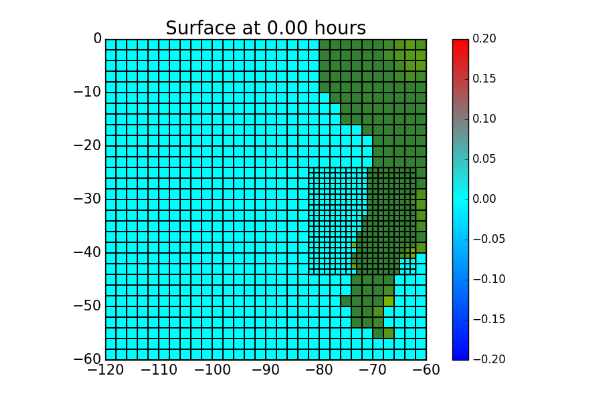
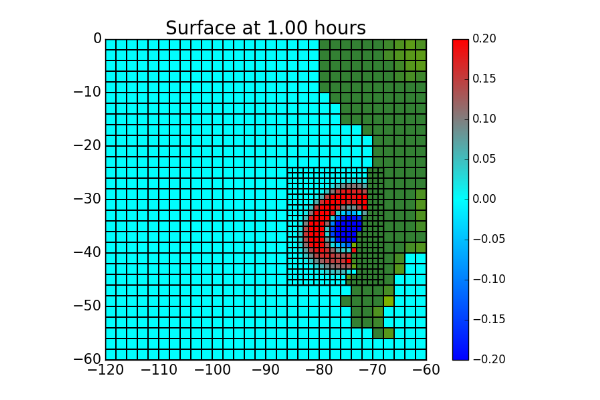
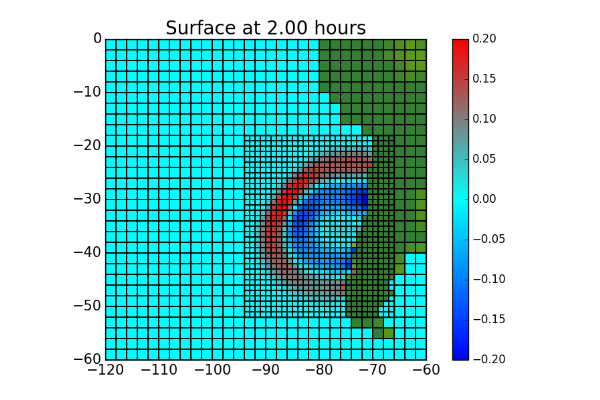
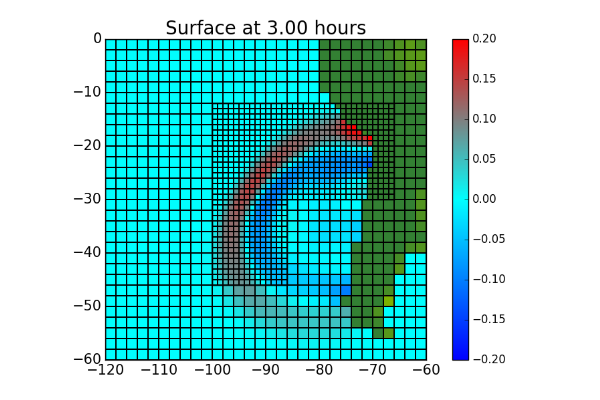
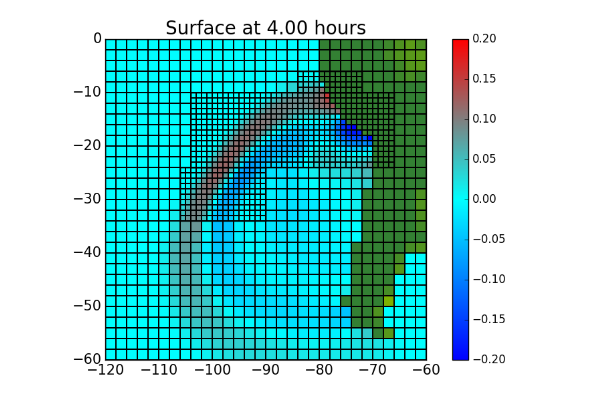
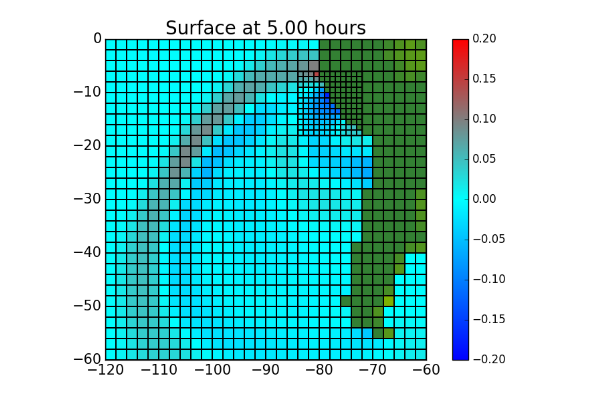

In [18]:
rundata.amrdata.amr_levels_max = 2
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
J.make_anim(plotdir, figno=0, figsize=(6,4))

Notice several things in this animation:

 - There are generally several patches of grids at Level 2 that might or might not be contiguous
 - The location of the patches changes with time to follow (parts of) the tsunami.
 - Some parts of the tsunami are not resolved on Level 2 at later times.
 
## Experiment 3: Changing the refinement criterion
 
There are several parameters in `setrun.py` that control the behavior of the AMR algorithms.  For example, the movement of the patches is due to the fact that re-gridding is performed every few time steps and the number of steps between regridding can be adjusted.  

When re-gridding is performed, some criteria are used to determine what regions need to be refined.  In this example we are simply flagging coarse cells as needing refinement whereever the amplitude of the surface (relative to sea level) is above some tolerance.  By making the tolerance smaller, we will cause more of the domain to be refined to Level 2 at letter times. 

Find the line 

    refinement_data.wave_tolerance = 0.1

in `setrun.py` and change it to:

    refinement_data.wave_tolerance = 0.02
    
Now re-run the code and you should see that it refines much more of the wave.  In fact at later times it refines almost the entire domain.

Below we make the same change in the notebook to display the new results.


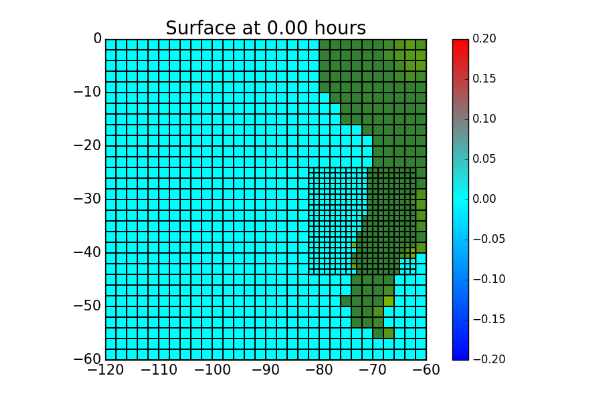
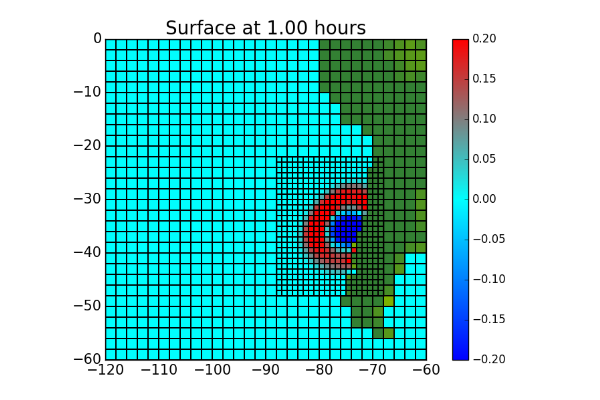
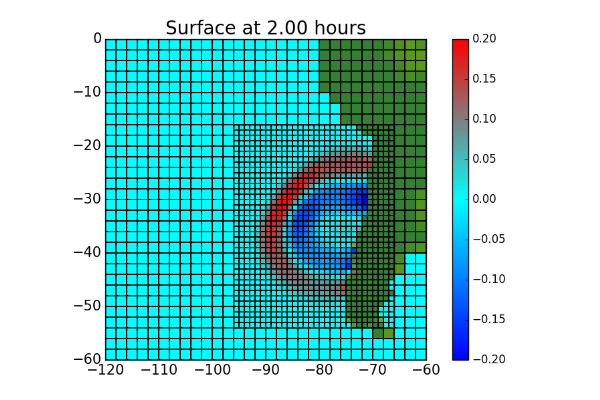
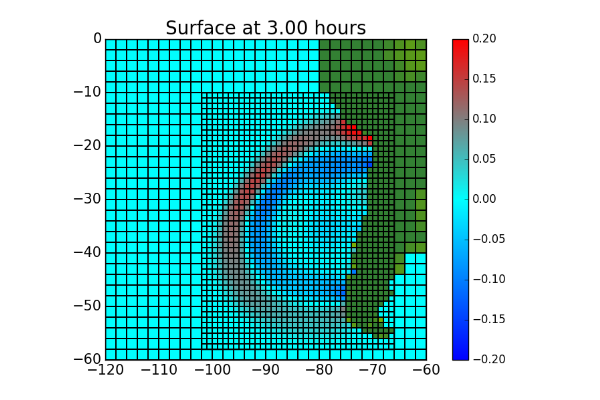
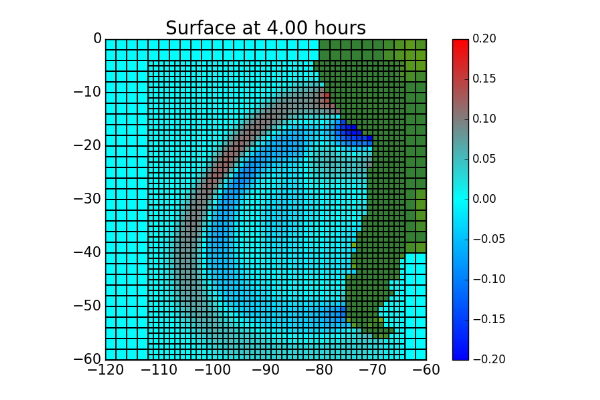
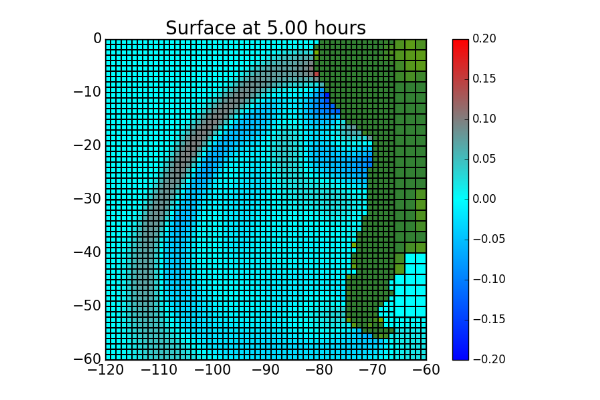

In [19]:
rundata.refinement_data.wave_tolerance = 0.02
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
J.make_anim(plotdir, figno=0, figsize=(6,4))

## Experiment 4 -- Adding a third level

Let's add a third level of AMR, refining by another factor of two in each dimension going from Level 2 to Level 3.  Do this by fixing `setrun.py` to have these lines:

    # max number of refinement levels:
    amrdata.amr_levels_max = 3

    # List of refinement ratios at each level:
    amrdata.refinement_ratios_x = [2,2]
    amrdata.refinement_ratios_y = [2,2]
    amrdata.refinement_ratios_t = [2,2]
    
Note that you have to add another component to the `refinement_ratios` to give the refinement factor from Level 2 to Level 3.  The refinement ratios do not have to be 2, they can be any integer.  In general you should refine by the same factors in `x` and `y`.

(*Note:* The refinement factors in `t` are actually ignored because of another line in `setrun.py` that tell GeoClaw to choose time steps appropriately at each level.)

If you make this change and run the code again, you should plots like those shown below.

Note that at Level 3 we are not plotting the grid lines (which would be so dense they hide the wave). Instead only the patch boundaries are shown.  Plotting behavior is controlled by parameters set in `setplot.py` explored later.


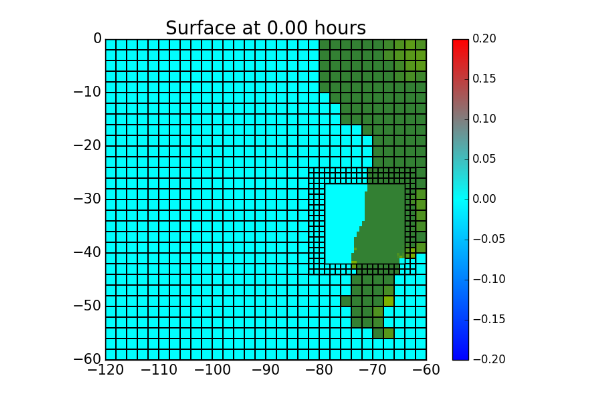
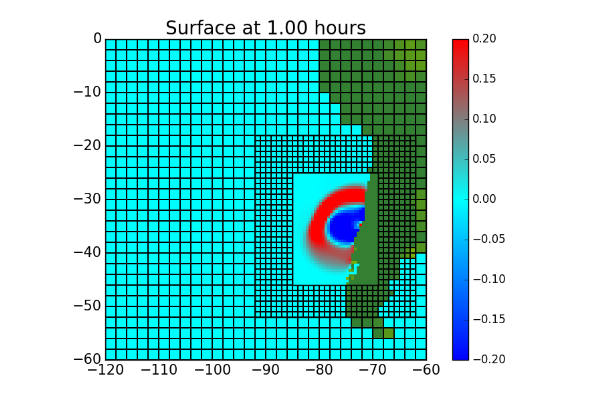
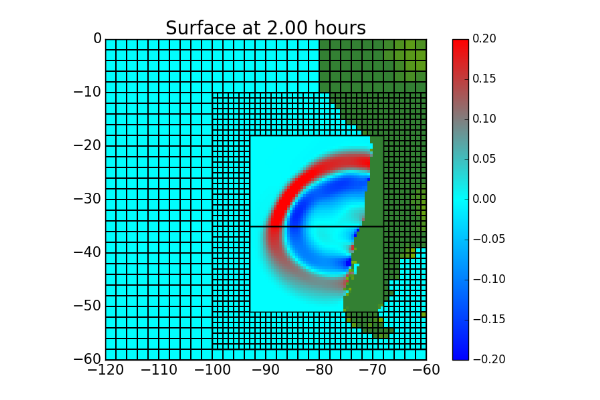
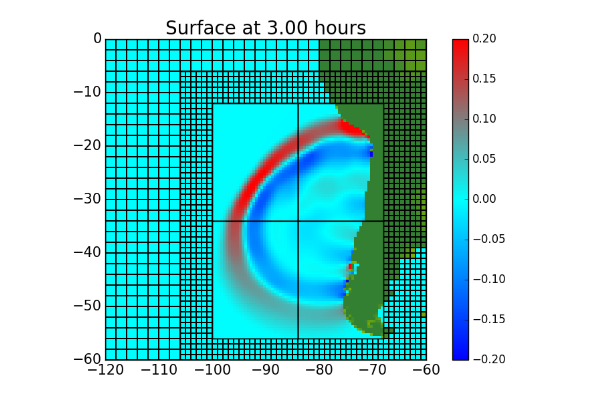
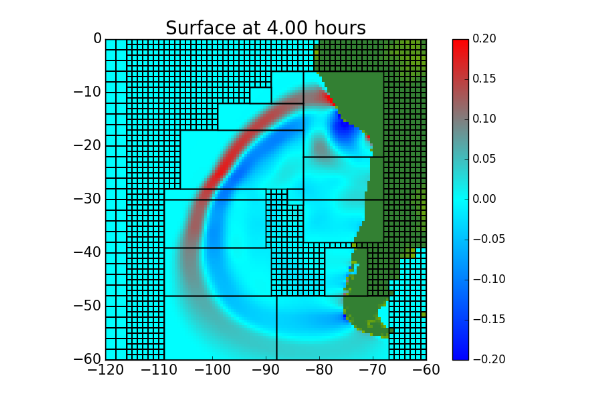
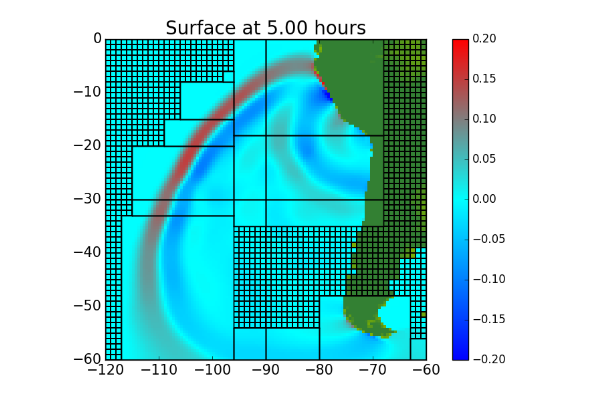

In [20]:
rundata.amrdata.amr_levels_max = 3
rundata.amrdata.refinement_ratios_x = [2,2]
rundata.amrdata.refinement_ratios_y = [2,2]
rundata.amrdata.refinement_ratios_t = [2,2]
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
J.make_anim(plotdir, figno=0, figsize=(6,4))

## Experiment 5 -- Restricting or forcing refinement in "regions"

In the last experiment we have resolved the tsunami fairly well everywhere.  The refinement criterion is simply the amplitude of the wave. 

In many applications we do not need to refine equally well everywhere, e.g. if we are only interested in modeling the effect of the tsunami on one particular coastline.  We would then like to restrict the regions where refinement to a certain level is allowed.  

We might also have particular regions where we want to **force** refinement to some level, over some time period.  For example around the earthquake source region, or a region on the coast where we want fine grids even if the tsunami is small there.

GeoClaw allows specifying rectangular regions in space-time over which refinement is required to be at least to Level $L_1$ and at most to level $L_2$.  Multiple regions can be specified, and this can be used in conjunction with flagging based on amplitude (whether a point is refined only to $L_1$ or to some higher level $\leq L_2$ depends on the amplitude).  If a point lies in more than one region, the maximum of $L_1$ values and the maximum of the $L_2$ values for each region are used as limits.  See [the documentation](http://www.clawpack.org/refinement.html#specifying-amr-regions) for more information.

In this experiment we will introduce 3 regions in this example.  Find these lines in `setrun.py`:

    rundata.regiondata.regions = []
    # to specify regions of refinement append lines of the form
    #  [minlevel,maxlevel,t1,t2,x1,x2,y1,y2]

    if 0:
        # Allow only level 1 as default everywhere:
        rundata.regiondata.regions.append([1, 1, 0., 1e9, -180, 180, -90, 90])

        # Force refinement around earthquake source region for first hour:
        rundata.regiondata.regions.append([3, 3, 0., 3600., -85,-72,-38,-25])

        # Allow up to level 3 in northeastern part of domain:
        rundata.regiondata.regions.append([1, 3, 0., 1.e9, -90,-60,-30,0])
        
These lines are effectively commented-out by the `if 0:`, so simply change `0` to `1` to specify the 3 regions. (`0=False, 1=True` in this context)

 - The first region simply sets the default to a maximum of 1 level anywhere.  
 - The second region forces refinement to Level 3 in the region around the earthquake source, but only for the first 3600 seconds.  
 - The third region allows up to 3 levels over the northeastern part of the domain ($x>-90,~y>-30$) which might be appropriate if we were only interested in the impact on the Peru coast, for example.
 
We can set these same regions in the notebook in order to produce the plots you should observe when you rerun the code:


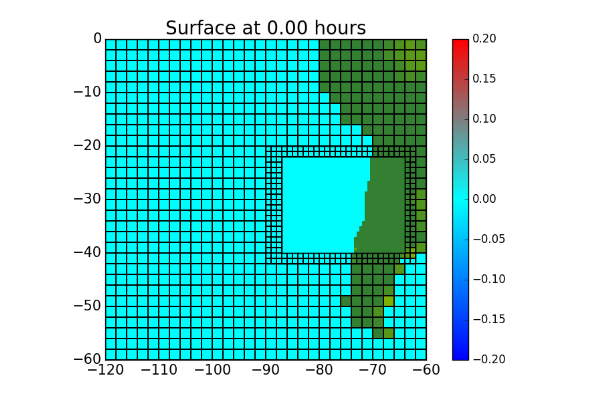
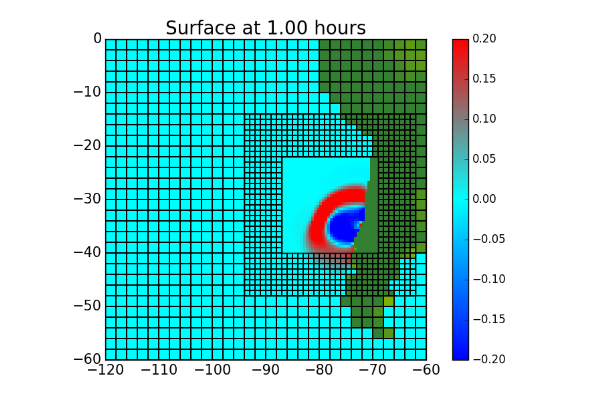
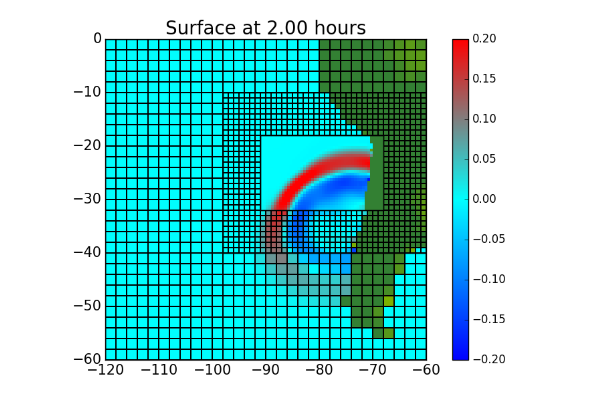
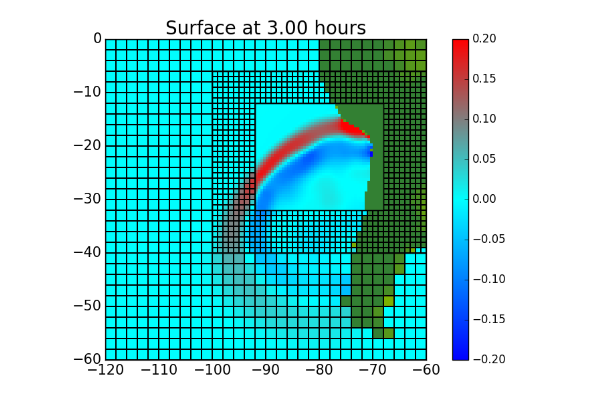
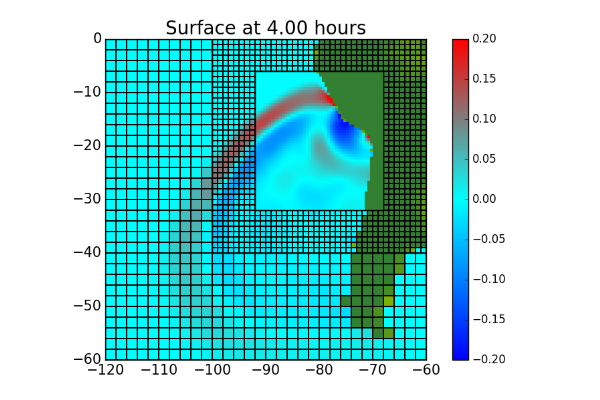
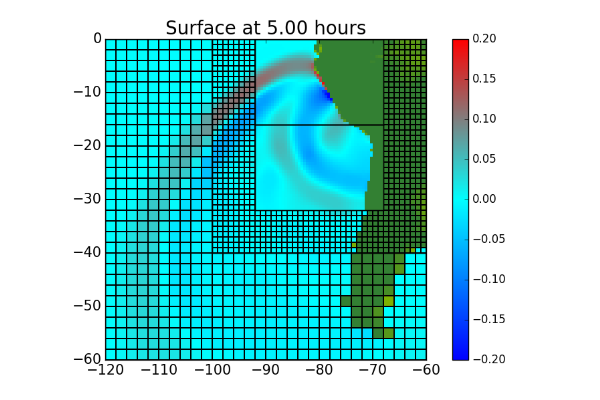

In [21]:
rundata.regiondata.regions = []  # empty list of regions

# Allow only level 1 as default everywhere:
rundata.regiondata.regions.append([1, 1, 0., 1e9, -180, 180, -90, 90])

# Force refinement around earthquake source region for first hour:
rundata.regiondata.regions.append([3, 3, 0., 3600., -85,-72,-38,-25])

# Allow up to level 3 in northeastern part of domain:
rundata.regiondata.regions.append([1, 3, 0., 1.e9, -90,-60,-30,0])

rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
J.make_anim(plotdir, figno=0, figsize=(6,4))

## Next step:

The directory `../chile2010b` explores this example further by adding some gauges to capture time series of the solution.